In [1]:
!pip install -q lightgbm xgboost catboost

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils import shuffle
import joblib
import warnings
warnings.filterwarnings("ignore")

# Tree boosters
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
print("Imports done")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
Imports done


In [2]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

TARGET = "spend_category"
IDCOL  = "trip_id"

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Target value counts:")

Train shape: (12654, 25)
Test shape: (5852, 24)
Target value counts:


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      12654 non-null  object 
 1   country                      12424 non-null  object 
 2   age_group                    12646 non-null  object 
 3   travel_companions            11917 non-null  object 
 4   num_females                  12652 non-null  float64
 5   num_males                    12650 non-null  float64
 6   main_activity                12526 non-null  object 
 7   visit_purpose                12654 non-null  object 
 8   is_first_visit               12555 non-null  object 
 9   mainland_stay_nights         12654 non-null  int64  
 10  island_stay_nights           12654 non-null  int64  
 11  tour_type                    12654 non-null  object 
 12  intl_transport_included      12507 non-null  object 
 13  info_source     

In [4]:
train.isnull().sum()

,0
trip_id,0
country,230
age_group,8
travel_companions,737
num_females,2
num_males,4
main_activity,128
visit_purpose,0
is_first_visit,99
mainland_stay_nights,0


In [5]:
train[train.duplicated()==True]

,trip_id,country,age_group,travel_companions,num_females,num_males,main_activity,visit_purpose,is_first_visit,mainland_stay_nights,...,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,days_booked_before_trip,arrival_weather,total_trip_days,has_special_requirements,spend_category


In [6]:
train['trip_id'].unique()

array(['tour_idftaa27vp', 'tour_iduck75m57', 'tour_id8y3w40h8', ...,
       'tour_id88nvd60z', 'tour_iddw9van5i', 'tour_idysv37iyh'],
      dtype=object)

In [7]:
train['country'].value_counts()

,count
country,
UNITED STATES OF AMERICA,1953
UNITED KINGDOM,1415
ITALY,1125
FRANCE,738
GERMANY,655
...,...
ESTONIA,1
NIGER,1
AFGHANISTAN,1


In [8]:
train['trip_id'].duplicated().sum()

np.int64(0)

In [9]:
train['age_group'].value_counts()

,count
age_group,
25-44,6146
45-64,3907
18-24,1500
65+,1011
<18,82


In [10]:
train['age_group'].unique()

array(['45-64', '25-44', '18-24', '65+', nan, '<18'], dtype=object)

In [11]:
train['travel_companions'].value_counts()

,count
travel_companions,
Alone,5088
With Spouse,3389
With Other Friends/Relatives,2221
With Spouse and Children,849
With Children,370


In [12]:
train['num_males'].value_counts()

,count
num_males,
1.0,8089
0.0,2904
2.0,1057
3.0,368
4.0,102
5.0,46
6.0,34
7.0,18
10.0,7


In [13]:
train['num_females'].value_counts()

,count
num_females,
1.0,6657
0.0,4152
2.0,1199
3.0,344
4.0,138
5.0,55
6.0,40
7.0,13
10.0,11


In [14]:
train['has_special_requirements'].value_counts()

,count
has_special_requirements,
none,2964
"dietary needs,",979
translator required.,504
"wheelchair,",90


In [15]:
test['has_special_requirements'].value_counts()

,count
has_special_requirements,
none,1377
"dietary needs,",477
translator required.,235
"wheelchair,",37


<Axes: >

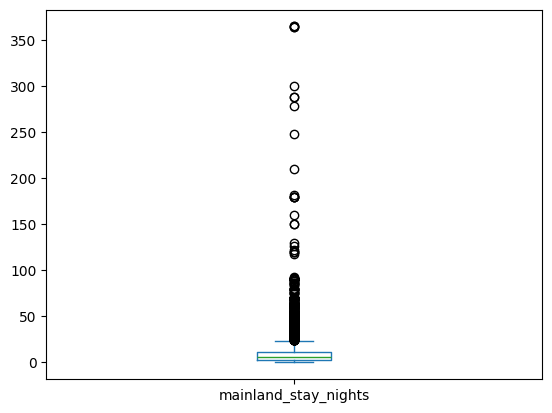

In [16]:
train['mainland_stay_nights'].plot(kind='box')

<Axes: >

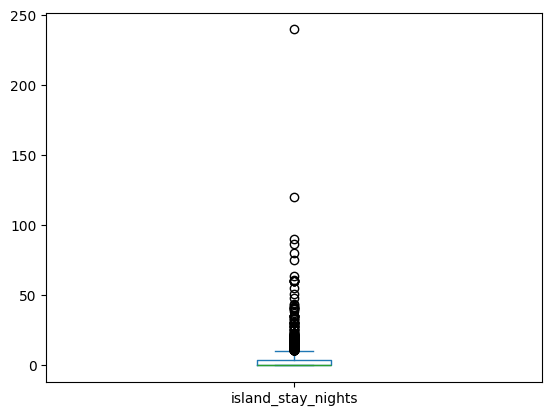

In [17]:
train['island_stay_nights'].plot(kind='box')

Cleaning

In [18]:
df_train = train.copy(deep = True)
df_test = test.copy(deep = True)

In [19]:
df_train[df_train['country'].isnull()]

,trip_id,country,age_group,travel_companions,num_females,num_males,main_activity,visit_purpose,is_first_visit,mainland_stay_nights,...,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,days_booked_before_trip,arrival_weather,total_trip_days,has_special_requirements,spend_category
384,tour_ids159y8aq,NaN,45-64,With Spouse,1.0,1.0,Widlife Tourism,Leisure and Holidays,Yes,10,...,Yes,Yes,Yes,Yes,Yes,15-30,"sunny,",7-14,NaN,0.0
416,tour_idxbxk8ogr,NaN,45-64,Alone,0.0,1.0,Wildlife Tourism,Visiting Friends and Relatives,No,5,...,No,No,No,No,No,90+,Rainy,30+,NaN,1.0
491,tour_idojvatsq6,NaN,45-64,Alone,1.0,0.0,Beach Tourism,Leisure and Holidays,No,0,...,No,No,No,No,No,15-30,other,1-6,NaN,1.0
511,tour_id78zs8ods,NaN,45-64,With Spouse,1.0,1.0,Wildlife Tourism,Leisure and Holidays,Yes,5,...,No,No,No,No,No,90+,other,7-14,NaN,1.0
587,tour_idyo3g99ng,NaN,25-44,With Spouse,1.0,1.0,Wildlife Tourism,Leisure and Holidays,Yes,7,...,Yes,Yes,Yes,Yes,Yes,NaN,"sunny,",1-6,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12497,tour_id596tzmmv,NaN,45-64,NaN,0.0,1.0,Conference Tourism,Leisure and Holidays,Yes,9,...,Yes,Yes,Yes,No,No,15-30,"sunny,",15-30,NaN,0.0
12588,tour_id0gxopp1d,NaN,25-44,Alone,0.0,1.0,Hunting Tourism,Leisure and Holidays,No,4,...,No,No,No,No,No,NaN,"cloudy,",1-6,translator required.,1.0
12620,tour_id1ql3citz,NaN,45-64,With Spouse and Children,2.0,3.0,Wildlife Tourism,Leisure and Holidays,Yes,22,...,Yes,Yes,Yes,Yes,No,31-60,Rainy,30+,NaN,1.0
12623,tour_iduur450d1,NaN,18-24,With Spouse,1.0,1.0,Beach Tourism,Leisure and Holidays,Yes,0,...,Yes,Yes,No,Yes,No,31-60,"sunny,",30+,translator required.,0.0


In [20]:
df_train = df_train.dropna(subset=['country'])

In [21]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,8
travel_companions,725
num_females,2
num_males,4
main_activity,126
visit_purpose,0
is_first_visit,99
mainland_stay_nights,0


In [22]:
df_train = df_train.dropna(subset=['age_group'])

In [23]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,725
num_females,2
num_males,4
main_activity,125
visit_purpose,0
is_first_visit,99
mainland_stay_nights,0


In [24]:
df_train[df_train['travel_companions'].isnull()]

,trip_id,country,age_group,travel_companions,num_females,num_males,main_activity,visit_purpose,is_first_visit,mainland_stay_nights,...,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,days_booked_before_trip,arrival_weather,total_trip_days,has_special_requirements,spend_category
9,tour_idp9abcjpc,KENYA,25-44,NaN,0.0,1.0,Beach Tourism,Other,No,3,...,No,No,No,No,No,61-90,"sunny,",1-6,NaN,1.0
19,tour_idweujd1m8,FRANCE,25-44,NaN,1.0,0.0,Conference Tourism,Leisure and Holidays,Yes,6,...,Yes,Yes,Yes,Yes,No,90+,humid,30+,NaN,1.0
41,tour_idq20yhdih,SWIZERLAND,45-64,NaN,1.0,0.0,Wildlife Tourism,Visiting Friends and Relatives,Yes,30,...,No,No,No,No,No,90+,"sunny,",7-14,NaN,1.0
44,tour_id5wa48pl8,UNITED KINGDOM,18-24,NaN,2.0,1.0,Cultural Tourism,Leisure and Holidays,Yes,50,...,No,No,No,No,No,61-90,Rainy,7-14,none,0.0
84,tour_iddotlpvba,ITALY,45-64,NaN,0.0,1.0,Cultural Tourism,Meetings and Conference,Yes,0,...,Yes,Yes,No,No,No,90+,NaN,7-14,"dietary needs,",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12498,tour_idum0bw2wx,UNITED STATES OF AMERICA,25-44,NaN,0.0,1.0,Conference Tourism,Leisure and Holidays,Yes,14,...,Yes,Yes,Yes,Yes,No,90+,other,30+,NaN,1.0
12552,tour_idg32vccmw,UNITED KINGDOM,45-64,NaN,0.0,1.0,Mountain Climbing,Meetings and Conference,No,3,...,No,No,No,No,No,61-90,"Windy,",7-14,NaN,1.0
12616,tour_idjdbues1j,TAIWAN,25-44,NaN,1.0,0.0,Wildlife Tourism,Leisure and Holidays,Yes,5,...,Yes,Yes,Yes,Yes,Yes,NaN,NaN,30+,NaN,0.0
12648,tour_idsxp0w533,KENYA,45-64,NaN,0.0,1.0,Hunting Tourism,Visiting Friends and Relatives,No,21,...,No,No,No,No,No,31-60,NaN,15-30,NaN,2.0


In [25]:
df_train['travel_companions'].value_counts()

,count
travel_companions,
Alone,4996
With Spouse,3318
With Other Friends/Relatives,2184
With Spouse and Children,833
With Children,360


In [26]:
df_train[(df_train['travel_companions'].isnull()) & ((df_train['num_males']+df_train['num_females'])==0)]

,trip_id,country,age_group,travel_companions,num_females,num_males,main_activity,visit_purpose,is_first_visit,mainland_stay_nights,...,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,days_booked_before_trip,arrival_weather,total_trip_days,has_special_requirements,spend_category
8146,tour_idvuqr4z1e,UGANDA,18-24,NaN,0.0,0.0,Beach Tourism,Leisure and Holidays,Yes,3,...,No,No,No,No,No,61-90,"sunny,",30+,none,2.0
9088,tour_idgiheohsx,UNITED STATES OF AMERICA,45-64,NaN,0.0,0.0,Wildlife Tourism,Leisure and Holidays,Yes,7,...,Yes,Yes,No,Yes,Yes,61-90,Stormy,1-6,none,0.0


In [27]:
index = df_train[(df_train['travel_companions'].isnull()) & ((df_train['num_males']+df_train['num_females'])==0)].index
for i in index:
    df_train.loc[i,'travel_companions'] = 'Alone'
df_train[(df_train['travel_companions'].isnull()) & ((df_train['num_males']+df_train['num_females'])==0)]

,trip_id,country,age_group,travel_companions,num_females,num_males,main_activity,visit_purpose,is_first_visit,mainland_stay_nights,...,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,days_booked_before_trip,arrival_weather,total_trip_days,has_special_requirements,spend_category


In [28]:
df_train = df_train.dropna(subset=['num_females'])
df_train = df_train.dropna(subset=['num_males'])
df_train = df_train.dropna(subset=['main_activity'])
df_train = df_train.dropna(subset=['is_first_visit'])
df_train = df_train.dropna(subset=['intl_transport_included'])
df_train = df_train.dropna(subset=['accomodation_included'])
df_train = df_train.dropna(subset=['food_included'])
df_train = df_train.dropna(subset=['insurance_included'])

In [29]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,668
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


In [30]:
df_train['days_booked_before_trip'].isnull().sum()

np.int64(1412)

In [31]:
df_train['days_booked_before_trip'] = df_train['days_booked_before_trip'].fillna(df_train['days_booked_before_trip'].mode)

In [32]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,668
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


In [33]:
df_train['arrival_weather'].value_counts()

,count
arrival_weather,
"sunny,",2920
Rainy,1688
"cloudy,",958
other,873
"Windy,",775
Stormy,714
humid,502


In [34]:
df_train.groupby(['tour_type','arrival_weather']).count()

trip_id  country  age_group  travel_companions  \
tour_type    arrival_weather                                                   
Independent  Rainy                819      819        819                746   
             Stormy               365      365        365                333   
             Windy,               362      362        362                333   
             cloudy,              461      461        461                430   
             humid                248      248        248                229   
             other                419      419        419                380   
             sunny,              1471     1471       1471               1352   
Package Tour Rainy                869      869        869                834   
             Stormy               349      349        349                338   
             Windy,               413      413        413                394   
             cloudy,              497      497        497                478   
             humid                254      254        254                240   
             other                454      454        454                433   
             sunny,              1449     1449       1449               1407   

                              num_females  num_males  main_activity  \
tour_type    arrival_weather                                          
Independent  Rainy                    819        819            819   
             Stormy                   365        365            365   
             Windy,                   362        362            362   
             cloudy,                  461        461            461   
             humid                    248        248            248   
             other                    419        419            419   
             sunny,                  1471       1471           1471   
Package Tour Rainy                    869        869            869   
             Stormy                   349        349            349   
             Windy,                   413        413            413   
             cloudy,                  497        497            497   
             humid                    254        254            254   
             other                    454        454            454   
             sunny,                  1449       1449           1449   

                              visit_purpose  is_first_visit  \
tour_type    arrival_weather                                  
Independent  Rainy                      819             819   
             Stormy                     365             365   
             Windy,                     362             362   
             cloudy,                    461             461   
             humid                      248             248   
             other                      419             419   
             sunny,                    1471            1471   
Package Tour Rainy                      869             869   
             Stormy                     349             349   
             Windy,                     413             413   
             cloudy,                    497             497   
             humid                      254             254   
             other                      454             454   
             sunny,                    1449            1449   

                              mainland_stay_nights  ...  \
tour_type    arrival_weather                        ...   
Independent  Rainy                             819  ...   
             Stormy                            365  ...   
             Windy,                            362  ...   
             cloudy,                           461  ...   
             humid                             248  ...   
             other                             419  ...   
             sunny,                           1471  ...   
Package Tour Rainy                             869  ...   
             

In [35]:
df_train['arrival_weather'] = df_train['arrival_weather'].fillna('sunny,')

In [36]:
df_train['arrival_weather'].value_counts()

,count
arrival_weather,
"sunny,",6021
Rainy,1688
"cloudy,",958
other,873
"Windy,",775
Stormy,714
humid,502


In [37]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,668
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


In [38]:
df_train = df_train.dropna(subset=['total_trip_days'])

In [39]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,643
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


In [40]:
df_train['has_special_requirements'].value_counts()

,count
has_special_requirements,
none,2642
"dietary needs,",860
translator required.,445
"wheelchair,",77


In [41]:
index = df_train[df_train['has_special_requirements'].isnull()].index
df_train.loc[index,'has_special_requirements'] = 'none'

In [42]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,643
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


Output Row to be removed

In [43]:
df_train = df_train.dropna(subset=['spend_category'])

In [44]:
df_train.isnull().sum()

,0
trip_id,0
country,0
age_group,0
travel_companions,640
num_females,0
num_males,0
main_activity,0
visit_purpose,0
is_first_visit,0
mainland_stay_nights,0


Handling Outliers

<Axes: >

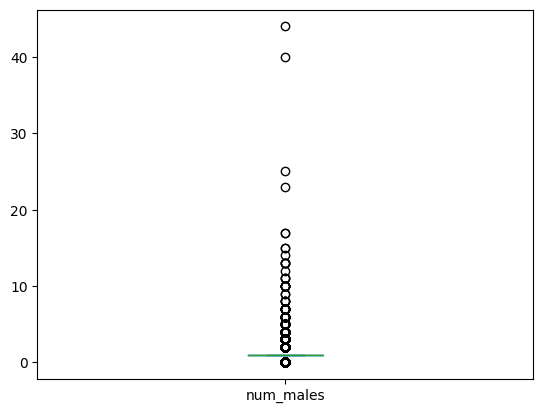

In [45]:
df_train['num_males'].plot(kind='box')

In [46]:
Q1 = df_train['num_males'].quantile(0.25)
Q3 = df_train['num_males'].quantile(0.75)
IQR = Q3 - Q1

# Step 3: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Count outliers
outliers = df_train[(df_train['num_males'] < lower_bound) | (df_train['num_males'] > upper_bound)]
outliers.shape

(4023, 25)

Since the percentage of outliers are so high we have thought that it would not be a good idea to cap or remove them.
Also while going through the data even the outliers seemed legit.

Even for island_stay_nights, mainland_stay_nights, num_females, we felt the same. Hence, did not remove any outliers.

Correcting spellings -

In [47]:
df_train['main_activity'].value_counts()

,count
main_activity,
Widlife Tourism,3627
Beach Tourism,2575
Wildlife Tourism,1388
Conference Tourism,1170
Hunting Tourism,982
Cultural Tourism,829
Mountain Climbing,293
Business,160
Bird Tourism,91


In [48]:
index = df_train[df_train['main_activity']=='Widlife Tourism'].index
df_train.loc[index,'main_activity'] = 'Wildlife Tourism'

In [49]:
index = df_test[df_test['main_activity']=='Widlife Tourism'].index
df_test.loc[index,'main_activity'] = 'Wildlife Tourism'

Solving the punctuation **problem**

In [50]:
df_train['has_special_requirements'].value_counts()

,count
has_special_requirements,
none,9754
"dietary needs,",858
translator required.,445
"wheelchair,",77


In [51]:
index = df_train[df_train['has_special_requirements']=='dietary needs,'].index
df_train.loc[index,'has_special_requirements'] = 'dietary needs'

In [52]:
index = df_test[df_test['has_special_requirements']=='dietary needs,'].index
df_test.loc[index,'has_special_requirements'] = 'dietary needs'

In [53]:
index = df_train[df_train['has_special_requirements']=='translator required.'].index
df_train.loc[index,'has_special_requirements'] = 'translator required'

In [54]:
index = df_test[df_test['has_special_requirements']=='translator required.'].index
df_test.loc[index,'has_special_requirements'] = 'translator required'

In [55]:
index = df_train[df_train['has_special_requirements']=='wheelchair,'].index
df_train.loc[index,'has_special_requirements'] = 'wheelchair'

In [56]:
index = df_test[df_test['has_special_requirements']=='wheelchair,'].index
df_test.loc[index,'has_special_requirements'] = 'wheelchair'

In [57]:
df_train['has_special_requirements'].value_counts()

,count
has_special_requirements,
none,9754
dietary needs,858
translator required,445
wheelchair,77


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11134 entries, 0 to 12652
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      11134 non-null  object 
 1   country                      11134 non-null  object 
 2   age_group                    11134 non-null  object 
 3   travel_companions            10494 non-null  object 
 4   num_females                  11134 non-null  float64
 5   num_males                    11134 non-null  float64
 6   main_activity                11134 non-null  object 
 7   visit_purpose                11134 non-null  object 
 8   is_first_visit               11134 non-null  object 
 9   mainland_stay_nights         11134 non-null  int64  
 10  island_stay_nights           11134 non-null  int64  
 11  tour_type                    11134 non-null  object 
 12  intl_transport_included      11134 non-null  object 
 13  info_source          

In [59]:
df_train['arrival_weather'].value_counts()

,count
arrival_weather,
"sunny,",5837
Rainy,1624
"cloudy,",918
other,834
"Windy,",747
Stormy,688
humid,486


In [60]:
index = df_train[df_train['arrival_weather']=='sunny,'].index
df_train.loc[index,'arrival_weather'] = 'sunny'

In [61]:
index = df_test[df_test['arrival_weather']=='sunny,'].index
df_test.loc[index,'arrival_weather'] = 'sunny'

In [62]:
index = df_train[df_train['arrival_weather']=='cloudy,'].index
df_train.loc[index,'arrival_weather'] = 'cloudy'

In [63]:
index = df_test[df_test['arrival_weather']=='cloudy,'].index
df_test.loc[index,'arrival_weather'] = 'cloudy'

In [64]:
index = df_train[df_train['arrival_weather']=='Windy,'].index
df_train.loc[index,'arrival_weather'] = 'Windy'

In [65]:
index = df_test[df_test['arrival_weather']=='Windy,'].index
df_test.loc[index,'arrival_weather'] = 'Windy'

In [66]:
df_train['arrival_weather'].value_counts()

,count
arrival_weather,
sunny,5837
Rainy,1624
cloudy,918
other,834
Windy,747
Stormy,688
humid,486


Changing column dtypes

In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11134 entries, 0 to 12652
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trip_id                      11134 non-null  object 
 1   country                      11134 non-null  object 
 2   age_group                    11134 non-null  object 
 3   travel_companions            10494 non-null  object 
 4   num_females                  11134 non-null  float64
 5   num_males                    11134 non-null  float64
 6   main_activity                11134 non-null  object 
 7   visit_purpose                11134 non-null  object 
 8   is_first_visit               11134 non-null  object 
 9   mainland_stay_nights         11134 non-null  int64  
 10  island_stay_nights           11134 non-null  int64  
 11  tour_type                    11134 non-null  object 
 12  intl_transport_included      11134 non-null  object 
 13  info_source          

In [68]:
columns_to_convert = [
    'country', 'age_group', 'travel_companions', 'main_activity',
    'visit_purpose', 'is_first_visit', 'has_special_requirements',
    'tour_type', 'intl_transport_included', 'info_source',
    'accomodation_included', 'food_included', 'domestic_transport_included',
    'sightseeing_included', 'guide_included', 'insurance_included',
    'days_booked_before_trip', 'arrival_weather', 'total_trip_days',
    'spend_category'
]


# Convert specified columns to categorical
df_train[columns_to_convert] = df_train[columns_to_convert].astype('category')

In [69]:
columns_to_convert = [
    'country', 'age_group', 'travel_companions', 'main_activity',
    'visit_purpose', 'is_first_visit', 'has_special_requirements',
    'tour_type', 'intl_transport_included', 'info_source',
    'accomodation_included', 'food_included', 'domestic_transport_included',
    'sightseeing_included', 'guide_included', 'insurance_included',
    'days_booked_before_trip', 'arrival_weather', 'total_trip_days'
]

df_test[columns_to_convert] = df_test[columns_to_convert].astype('category')

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11134 entries, 0 to 12652
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   trip_id                      11134 non-null  object  
 1   country                      11134 non-null  category
 2   age_group                    11134 non-null  category
 3   travel_companions            10494 non-null  category
 4   num_females                  11134 non-null  float64 
 5   num_males                    11134 non-null  float64 
 6   main_activity                11134 non-null  category
 7   visit_purpose                11134 non-null  category
 8   is_first_visit               11134 non-null  category
 9   mainland_stay_nights         11134 non-null  int64   
 10  island_stay_nights           11134 non-null  int64   
 11  tour_type                    11134 non-null  category
 12  intl_transport_included      11134 non-null  category
 13  info_s

Data Visualization

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Copying the training data frame for visualization
df_viz = df_train.copy(deep = True)

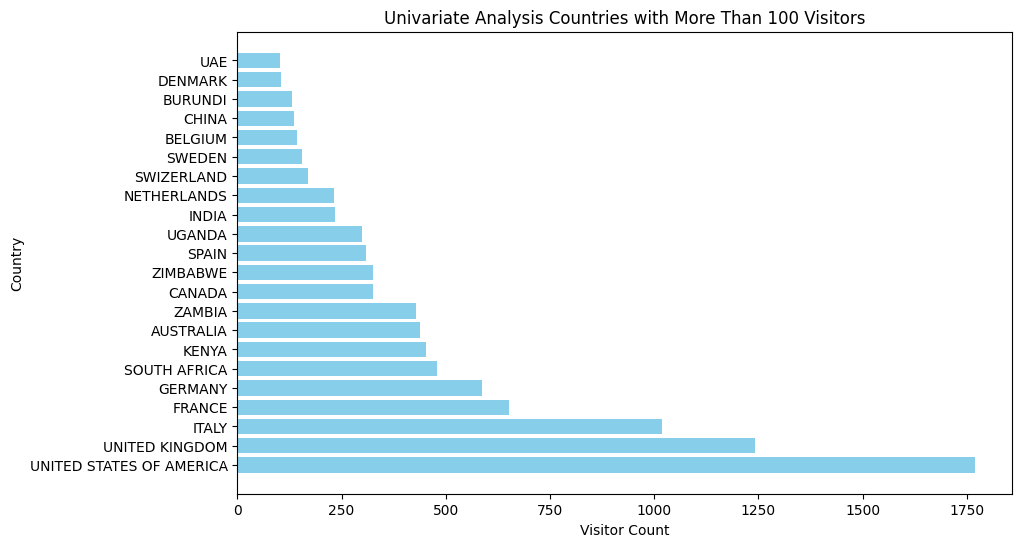

In [72]:
country_visits = df_viz['country'].value_counts()
high_visit_countries = country_visits[country_visits > 100]   # Filtering countries with more than 100 visitors

plt.figure(figsize=(10, 6))
plt.barh(high_visit_countries.index, high_visit_countries.values, color='skyblue')
plt.title('Univariate Analysis Countries with More Than 100 Visitors')
plt.ylabel('Country')
plt.xlabel('Visitor Count')
plt.show()


Inference:
The bar chart represents the number of visitors from different countries with more than 100 visitors.


The United States of America is at the top count; followed by the United Kingdom and then Italy, which indicates a significantly higher interest or degree of engagement in these countries compared to any other in the list. All the other countries are at a gradually decreasing count, that indicates variable degrees of interest and access to the source that attracts these visitors.

In [73]:
fig = px.pie(df_viz, names='age_group', title='Univariate Analysis of Age Bracket',
             hover_data=['age_group'],
             labels={'age_group':'Age Group'},
             width=800, height=600)

fig.update_layout(title={'x': 0.5})

fig.show()


Inference:
The pie chart has a univariate analysis of different age groups. The largest population is that of the 25-44 year bracket with 48.6% total.



Following them are the 45-64 year bracket with 30.9%. Finally, the remaining amounts are assigned to the 18-24, at 11.8%, the 65+, 8.07% and 0.665% for the under 18 year bracket. Thus, middle-aged adults from the 25-44 year bracket form the majority.

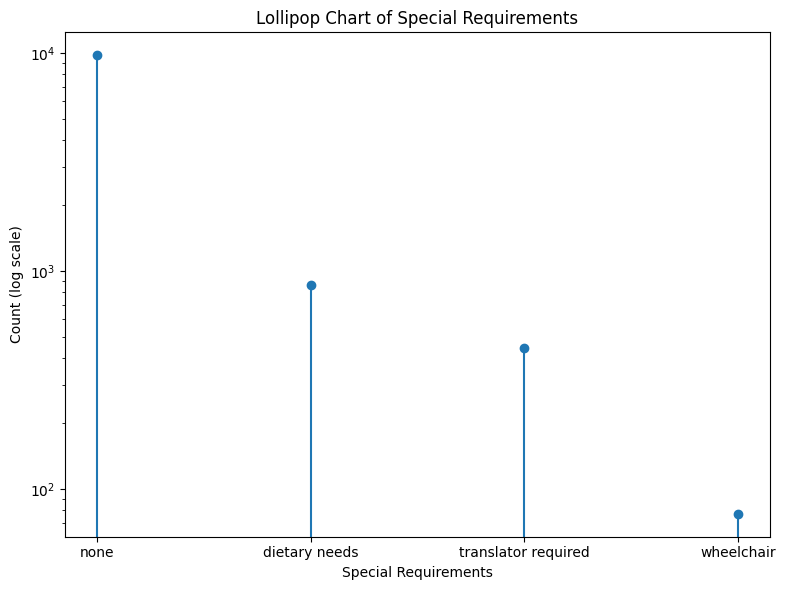

In [74]:
special_requirements_counts = df_viz['has_special_requirements'].value_counts().reset_index()
special_requirements_counts.columns = ['Requirement', 'Count']

plt.figure(figsize=(8, 6))
plt.stem(special_requirements_counts['Requirement'], special_requirements_counts['Count'], linefmt='-', markerfmt='o', basefmt=" ")
plt.title('Lollipop Chart of Special Requirements')
plt.xlabel('Special Requirements')
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.tight_layout()
plt.show()


Inference:
From the lollipop chart, it is evident that the largest majority of travelers do not have special requirements, as pointed out by the largest count.



 Among those with special requirements, dietary requirements take the first position and secondly come translators or translation assistance. The least requested assistance comes from wheelchair aid. It tells that even though most travelers do not require any special arrangements at all, when they do so, it is primarily on dietary and language issues.

In [75]:
df_viz['is_first_visit'] = df_viz['is_first_visit'].replace({"Yes": 'First Time', "No": 'Returning'}).astype(str)
df_viz['info_source'] = df_viz['info_source'].astype(str)

fig = px.sunburst(
    df_viz,
    path=['is_first_visit', 'info_source'],  # Hierarchical path
    title='Sunburst Chart of First Time Visitor and Source of Information',
    color='is_first_visit'
)

fig.update_traces(hovertemplate="%{value} visitors")
fig.update_layout(width=700, height=700, title={'x': 0.5})

fig.show()


Inference:

The sunburst chart illustrates the distribution of information sources by visitor type (first-time vs. returning). First-time visitors predominantly rely on travel agents or tour operators, with friends and relatives also serving as a significant source. Returning visitors exhibit a similar pattern, though they have a broader spread across various sources, including traditional media and friends. This suggests that first-time visitors tend to seek guidance through professional channels, while returning visitors use a more diverse array of information sources.

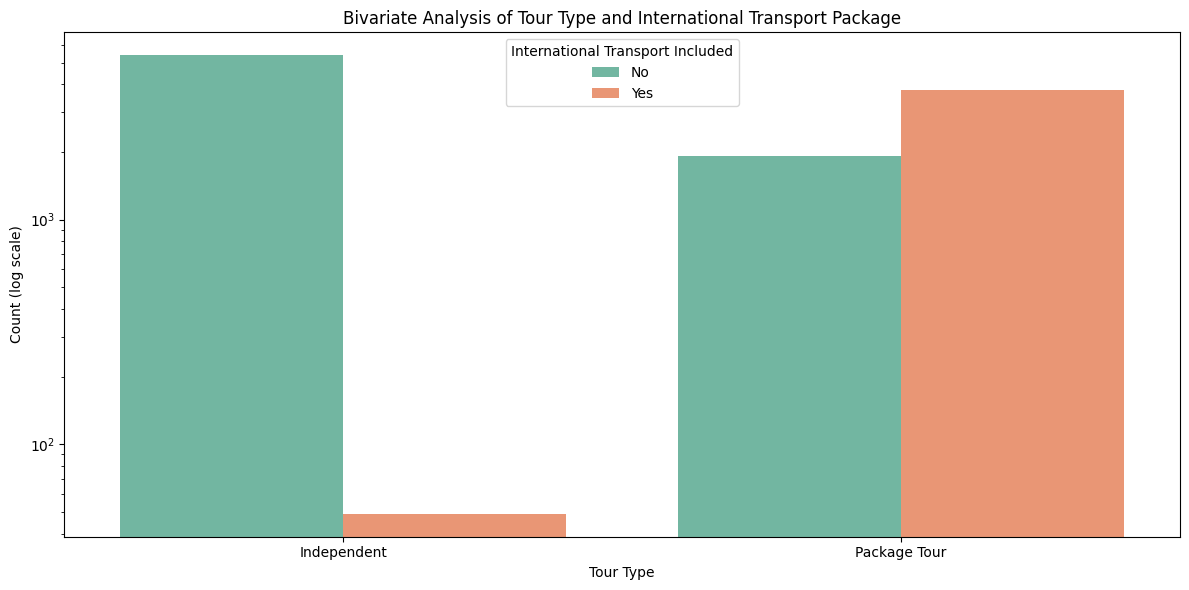

In [76]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_viz,
    x='tour_type',
    hue='intl_transport_included',
    palette='Set2'
)
plt.yscale('log')
plt.title('Bivariate Analysis of Tour Type and International Transport Package')
plt.xlabel('Tour Type')
plt.ylabel('Count (log scale)')
plt.legend(title='International Transport Included')
plt.tight_layout()
plt.show()


Inference:

This bar graph represents a bivariate analysis of tour arrangements, Independent vs. Package Tour, and whether an international transport package was included. The plot indicates that independent travelers were significantly more likely not to have a transport package while those taking a package tour were divided about equally between having a transport package or not having one. Therefore, by inference, transport packages appear to be something more likely to accompany an organized tour rather than independent travel.

The log scale puts emphasis on the significant count difference in differences between independent travel without a package and the other two.

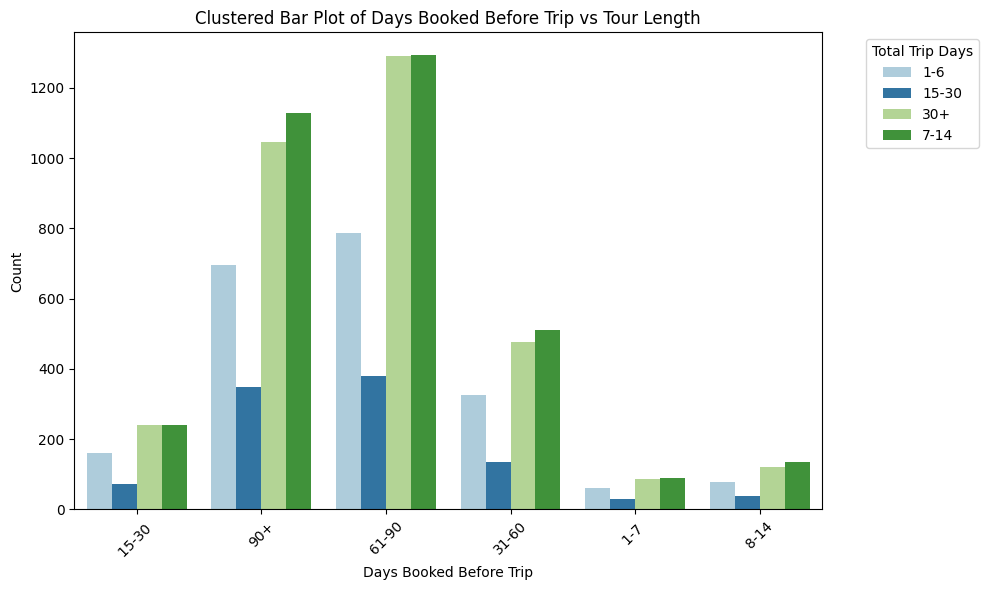

In [77]:
# Filtering data for visual clarity
df_viz2 = df_viz.copy(deep=True)
df_viz2['days_booked_before_trip'] = df_viz2['days_booked_before_trip'].astype(str)

# Replace any invalid values containing 'bound' (if appears) with NaN
df_viz2.loc[df_viz2['days_booked_before_trip'].str.contains('bound', case=False, na=False), 'days_booked_before_trip'] = np.nan

# Drop rows where it's None or NaN
df_viz2 = df_viz2.dropna(subset=['days_booked_before_trip'])

plt.figure(figsize=(10, 6))
sns.countplot(data=df_viz2, x='days_booked_before_trip', hue='total_trip_days', palette='Paired')

plt.title('Clustered Bar Plot of Days Booked Before Trip vs Tour Length')
plt.xlabel('Days Booked Before Trip')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Total Trip Days', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Inference:

The clustered bar plot shows the relationship between the days before booking and the tour length. Most bookings were made well in advance, particularly in the 61-90 and 90+ day categories, with longer tours (30+ days and 7-14 days) being the most common in these early bookings. Shorter bookings, especially in the 1-7 and 8-14 day ranges, are rare and typically for shorter tours (1-6 days). This suggests that travelers planning longer trips tend to book further in advance, while shorter tours have a more flexible booking window.

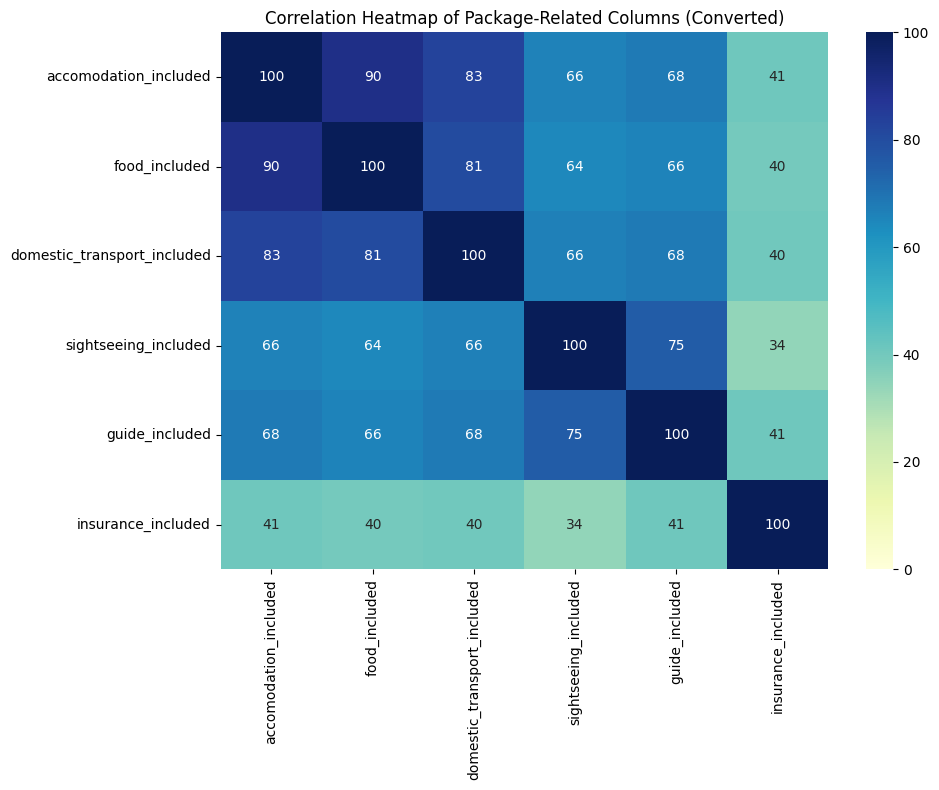

In [78]:
# Selecting package-related variables based on updated column names
package_data = df_viz[['accomodation_included', 'food_included', 'domestic_transport_included',
                       'sightseeing_included', 'guide_included', 'insurance_included']]

# Converting 'Yes'/'No' to 1/0 for better numerical processing
package_data_numeric = package_data.replace({'Yes': 1, 'No': 0})

# Calculating the correlation matrix and scaling to %
correlation_matrix = package_data_numeric.corr() * 100

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".0f", cmap='YlGnBu', vmin=0, vmax=100)
plt.title('Correlation Heatmap of Package-Related Columns (Converted)')
plt.tight_layout()
plt.show()


Inference:

The heatmap obviously shows there are many strong associations between some package types, especially among accommodation, food, and transport packages-suggesting these are frequently combined. Sightseeing and guided tours also have a moderate correlation. The insurance package is weakly associated with other packages, implying that it commonly occurs as an independent purchase. This may well suggest a pattern where some combinations of packages are commonly selected but insurance tends to be added on in most cases.

# Feature Engineering

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11134 entries, 0 to 12652
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   trip_id                      11134 non-null  object  
 1   country                      11134 non-null  category
 2   age_group                    11134 non-null  category
 3   travel_companions            10494 non-null  category
 4   num_females                  11134 non-null  float64 
 5   num_males                    11134 non-null  float64 
 6   main_activity                11134 non-null  category
 7   visit_purpose                11134 non-null  category
 8   is_first_visit               11134 non-null  category
 9   mainland_stay_nights         11134 non-null  int64   
 10  island_stay_nights           11134 non-null  int64   
 11  tour_type                    11134 non-null  category
 12  intl_transport_included      11134 non-null  category
 13  info_s

We are doing the following steps in order to make our data ready for classification of expenditure category:

The columns trip_id,info_source,travel_companions should have no effect on the expenditure of a person and hence will be removed.

The columns num_females and num_males will be merged into one called grp_count by adding their values amd the clmns num_females and num_males will be removed.
We tried to this but then realised this is a bad idea because expenditure may have something to do with the gender ratio of the grp and not just the grp size.Therefore we have opted to keep all three columns.

In [80]:
columns_to_drop = ['trip_id', 'info_source', 'travel_companions']

# Drop the columns
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

In [81]:
df_train['grp_count'] = df_train['num_females'] + df_train['num_males']
df_test['grp_count'] = df_test['num_females'] + df_test['num_males']

df_train['total_nights'] = df_train['island_stay_nights'] + df_train['mainland_stay_nights']
df_test['total_nights'] = df_test['island_stay_nights'] + df_test['mainland_stay_nights']

In [82]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   country                      5726 non-null   category
 1   age_group                    5852 non-null   category
 2   num_females                  5852 non-null   float64 
 3   num_males                    5850 non-null   float64 
 4   main_activity                5787 non-null   category
 5   visit_purpose                5852 non-null   category
 6   is_first_visit               5813 non-null   category
 7   mainland_stay_nights         5852 non-null   int64   
 8   island_stay_nights           5852 non-null   int64   
 9   tour_type                    5852 non-null   category
 10  intl_transport_included      5795 non-null   category
 11  accomodation_included        5790 non-null   category
 12  food_included                5774 non-null   category
 13  dom

In [83]:
df_test.isnull().sum()

,0
country,126
age_group,0
num_females,0
num_males,2
main_activity,65
visit_purpose,0
is_first_visit,39
mainland_stay_nights,0
island_stay_nights,0
tour_type,0


# Model Training

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import re

# Step 1: Data Preprocessing for df_train and df_test
df_train_copy = df_train.copy()  # Work with a fresh copy of the train data

# Function to clean column names (XGBoost requirement)
def clean_feature_names(columns):
    return [re.sub(r"[<>\[\]]", "", col) for col in columns]

# Clean categorical columns in both df_train and df_test
def clean_column(column):
    return column.apply(lambda x: str(x) if pd.notnull(x) else x)

for col in df_train_copy.select_dtypes(include='category').columns:
    df_train_copy[col] = clean_column(df_train_copy[col])

for col in df_test.select_dtypes(include='category').columns:
    df_test[col] = clean_column(df_test[col])

# Separate features and target variable in df_train
X = df_train_copy.drop(columns=['spend_category'])  # Features
y = df_train_copy['spend_category']                 # Target variable

# Step 2: OneHotEncoding for categorical variables, including 'country'
country_combined = pd.concat([X['country'], df_test['country']], axis=0).dropna().unique()
X['country'] = pd.Categorical(X['country'], categories=country_combined)
df_test['country'] = pd.Categorical(df_test['country'], categories=country_combined)

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Identify categorical columns to encode
categorical_columns = X.select_dtypes(include='category').columns

# Fit encoder on df_train and transform both df_train and df_test
X_encoded = encoder.fit_transform(X[categorical_columns])
X_test_encoded = encoder.transform(df_test[categorical_columns])

# Convert encoded arrays to DataFrames
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Combine encoded columns with remaining non-categorical columns
X_final = pd.concat([X_encoded_df, X.drop(columns=categorical_columns).reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, df_test.drop(columns=categorical_columns).reset_index(drop=True)], axis=1)

# Clean feature names for XGBoost
X_final.columns = clean_feature_names(X_final.columns)
X_test_final.columns = clean_feature_names(X_test_final.columns)

# Fill NaN values with 0
X_final = X_final.fillna(0)
X_test_final = X_test_final.fillna(0)

# Ensure target variable is integer-encoded
y = y.astype(float).astype(int)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=101)
X_train, y_train = smote.fit_resample(X_final, y)


In [85]:
X_train.shape

(16461, 172)

In [86]:
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
np.random.seed(101)
tf.random.set_seed(101)
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_columns = X_final.columns.difference(encoder.get_feature_names_out(categorical_columns))

# Initialize the scaler
scaler = StandardScaler()

# Scale only numerical features for training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test_final[numerical_columns])

# Ensure the target variable is integer-encoded
y_train = y_train.astype(int)

# Preprocessing complete
print("Preprocessing completed. Data is ready for model training!")

Preprocessing completed. Data is ready for model training!


# Training the models with default Parameters

In [87]:
# Step 1: Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='multinomial')
log_reg.fit(X_train_scaled, y_train)

# Predictions on train and test
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_lr = log_reg.predict(X_test_scaled)

# Evaluate on training set
print("Logistic Regression F1 Score:", f1_score(y_train, y_pred_train, average='weighted'))

# Create submission DataFrame
submission = pd.DataFrame({
    'trip_id': test['trip_id'],  # make sure 'trip_id' exists in your test set
    'spend_category': y_pred_lr
})

# Save submission to CSV
submission.to_csv("logistic_regression.csv", index=False)
print("Submission saved as logistic_regression.csv")


Logistic Regression F1 Score: 0.7278851827131045
Submission saved as logistic_regression.csv


In [96]:
# Step 2: Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', probability=True, random_state=101)
svm_model.fit(X_train_scaled, y_train)

# Predictions on train and test
y_pred_train = svm_model.predict(X_train_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate on training set
print("Support Vector Machine F1 Score:", f1_score(y_train, y_pred_train, average='weighted'))

# Create submission DataFrame
submission_svm = pd.DataFrame({
    'trip_id': test['trip_id'],  # make sure 'trip_id' exists in your test set
    'spend_category': y_pred_svm
})

# Save submission to CSV
submission_svm.to_csv("svm.csv", index=False)
print("Submission saved as svm.csv")


Support Vector Machine F1 Score: 0.7902303021321249
Submission saved as svm.csv


In [90]:
# Step 3: Neural Network
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model silently
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions on train and test
y_pred_train = nn_model.predict(X_train_scaled)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_nn = nn_model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_nn, axis=1)

# Evaluate on training set
print("Neural Network F1 Score:", f1_score(y_train, y_pred_train, average='weighted'))

# Create submission DataFrame
submission_nn = pd.DataFrame({
    'trip_id': test['trip_id'],  # make sure 'trip_id' exists in your test set
    'spend_category': y_pred_nn
})

# Save submission to CSV
submission_nn.to_csv("neural_network.csv", index=False)
print("Submission saved as neural_network.csv")


515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network F1 Score: 0.9310551151024441
Submission saved as neural_network.csv


In [91]:
!pip install -q lightgbm xgboost catboost
from catboost import CatBoostClassifier

# Initialize CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    random_seed=101,
    verbose=0
)


# Fit the model
cat_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train_cat = cat_model.predict(X_train_scaled)
y_pred_cat = cat_model.predict(X_test_scaled)

# Evaluate on train set
print("CatBoost F1 Score:", f1_score(y_train, y_pred_train_cat, average='weighted'))

# Submission DataFrame
submission_cat = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': y_pred_cat.flatten()   # flatten because CatBoost returns shape (n,1)
})

# Save as CSV
submission_cat.to_csv("catboost_submission.csv", index=False)
print("Submission saved as catboost_submission.csv")


CatBoost F1 Score: 0.8221191531364688
Submission saved as catboost_submission.csv


In [97]:
# =====================
# STACKING (CatBoost + SVM)
# =====================

# Validation predictions
cat_val_pred = cat_model.predict_proba(X_train_scaled)   # shape: (n, C)
svm_val_pred = svm_model.predict_proba(X_train_scaled)   # shape: (n, C)

# Stack meta-features (probabilities)
stack_val = np.hstack([cat_val_pred, svm_val_pred])

# Stacker = Logistic Regression
stacker = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    multi_class='multinomial'
)

# Train stacker
stacker.fit(stack_val, y_train)

# Predict on validation
stack_val_pred = stacker.predict(stack_val)

# Validation F1
stack_f1 = f1_score(y_train, stack_val_pred, average="macro")
print(f"\nStacked Ensemble Validation F1: {stack_f1:.4f}")


Stacked Ensemble Validation F1: 0.8236


In [93]:
# =====================
# STACKING (CatBoost + SVM + Logistic Regression)
# =====================

# Validation predictions (probabilities)
cat_val_pred = cat_model.predict_proba(X_train_scaled)      # (n, C)
svm_val_pred = svm_model.predict_proba(X_train_scaled)      # (n, C)
lr_val_pred  = log_reg.predict_proba(X_train_scaled)        # (n, C)

# Stack meta-features horizontally
stack_val = np.hstack([cat_val_pred, svm_val_pred, lr_val_pred])

# Meta-model (Logistic Regression)
stacker = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    multi_class='multinomial'
)

# Train stacker using validation meta-features
stacker.fit(stack_val, y_train)

# Predict on validation stack
stack_val_pred = stacker.predict(stack_val)

# Score
stack_f1 = f1_score(y_train, stack_val_pred, average="macro")
print(f"\nStacked Ensemble Validation F1: {stack_f1:.4f}")



Stacked Ensemble Validation F1: 0.8764


In [95]:
# =====================
# FINAL STACKED SUBMISSION (NO INDEX)
# =====================

# Retrain CatBoost on full train
cat_model.fit(X_train_scaled, y_train)
cat_test_pred = cat_model.predict_proba(X_test_scaled)

# Retrain SVM on full train
svm_model.fit(X_train_scaled, y_train)
svm_test_pred = svm_model.predict_proba(X_test_scaled)

# Retrain Logistic Regression on full train and get test predictions
log_reg.fit(X_train_scaled, y_train)
lr_test_pred = log_reg.predict_proba(X_test_scaled)

# Stack the test probabilities
stack_test = np.hstack([cat_test_pred, svm_test_pred, lr_test_pred])

# Final stacked prediction
final_preds = stacker.predict(stack_test)

# Submission
submission_stack = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': final_preds
})

submission_stack.to_csv("stacked_submission1.csv", index=False)
print("Final Stacked Submission saved as stacked_submission.csv")

Final Stacked Submission saved as stacked_submission.csv


In [98]:
# =====================
# FINAL STACKED SUBMISSION (NO INDEX)
# =====================

# Retrain CatBoost on full train
cat_model.fit(X_train_scaled, y_train)
cat_test_pred = cat_model.predict_proba(X_test_scaled)

# Retrain SVM on full train
svm_model.fit(X_train_scaled, y_train)
svm_test_pred = svm_model.predict_proba(X_test_scaled)


# Stack the test probabilities
stack_test = np.hstack([cat_test_pred, svm_test_pred])

# Final stacked prediction
final_preds = stacker.predict(stack_test)

# Submission
submission_stack = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': final_preds
})

submission_stack.to_csv("stacked_submission.csv", index=False)
print("Final Stacked Submission saved as stacked_submission.csv")

Final Stacked Submission saved as stacked_submission.csv


# Tuning

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Function to create NN model
def create_nn_model(dropout_rate=0.3, optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier
nn_model_tuned = KerasClassifier(build_fn=create_nn_model, verbose=0)

# Parameter grid
param_grid_nn = {
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['adam', 'sgd'],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Grid Search with 3-fold CV
grid_search_nn = GridSearchCV(estimator=nn_model_tuned, param_grid=param_grid_nn, cv=3, scoring='f1_weighted', n_jobs=-1)

# Fit grid search
grid_search_nn.fit(X_train_scaled, y_train)

# Predictions on train and test
y_pred_train_nn = grid_search_nn.best_estimator_.predict(X_train_scaled)
y_pred_test_nn = grid_search_nn.best_estimator_.predict(X_test_scaled)

# Evaluate
print("Neural Network with tuning F1 Score:", f1_score(y_train, y_pred_train_nn, average='weighted'))

# Create submission DataFrame
submission_nn_tuned = pd.DataFrame({
    'trip_id': test['trip_id'],  # ensure 'trip_id' exists in your test set
    'spend_category': y_pred_test_nn
})

# Save submission to CSV
submission_nn_tuned.to_csv("neural_network_tuned.csv", index=False)
print("Submission saved as neural_network_tuned.csv")


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=101)

# Grid Search with 5-fold cross-validation
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on training data
grid_search_lr.fit(X_train_scaled, y_train)

# Predictions on train and test
y_pred_train_tuned = grid_search_lr.best_estimator_.predict(X_train_scaled)
y_pred_test_tuned = grid_search_lr.best_estimator_.predict(X_test_scaled)

# Evaluate on training set
print("Logistic Regression with tuning F1 Score:", f1_score(y_train, y_pred_train_tuned, average='weighted'))

# Create submission DataFrame
submission_lr_tuned = pd.DataFrame({
    'trip_id': test['trip_id'],  # make sure 'trip_id' exists in your test set
    'spend_category': y_pred_test_tuned
})

# Save submission to CSV
submission_lr_tuned.to_csv("logistic_regression_tuned.csv", index=False)
print("Submission saved as logistic_regression_tuned.csv")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# MUCH FASTER GRID
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],        # keep only good kernels
    'gamma': ['scale', 'auto', 0.01, 0.1]  # only used for RBF
}

# Initialize SVM
svm_model = SVC(probability=True, random_state=101)

# Grid Search with faster CV
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    cv=3,                       # 3-fold CV is fine for SVM
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search_svm.fit(X_train_scaled, y_train)

# Best estimator
best_svm = grid_search_svm.best_estimator_
print("Best Params:", grid_search_svm.best_params_)

# Predict
y_pred_train_svm = best_svm.predict(X_train_scaled)
y_pred_test_svm = best_svm.predict(X_test_scaled)

# Train F1
print("Fast Tuned SVM F1 Score:", f1_score(y_train, y_pred_train_svm, average='weighted'))

# Submission
submission_svm_tuned = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': y_pred_test_svm
})

submission_svm_tuned.to_csv("svm_tuned.csv", index=False)
print("Submission saved as svm_tuned.csv")
